In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('fastfood.csv')
df.head()

,restaurant,item,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,vit_a,vit_c,calcium,salad
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380,60,7,2.0,0.0,95,1110,44,3.0,11,37.0,4.0,20.0,20.0,Other
1,Mcdonalds,Single Bacon Smokehouse Burger,840,410,45,17.0,1.5,130,1580,62,2.0,18,46.0,6.0,20.0,20.0,Other
2,Mcdonalds,Double Bacon Smokehouse Burger,1130,600,67,27.0,3.0,220,1920,63,3.0,18,70.0,10.0,20.0,50.0,Other
3,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750,280,31,10.0,0.5,155,1940,62,2.0,18,55.0,6.0,25.0,20.0,Other
4,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920,410,45,12.0,0.5,120,1980,81,4.0,18,46.0,6.0,20.0,20.0,Other


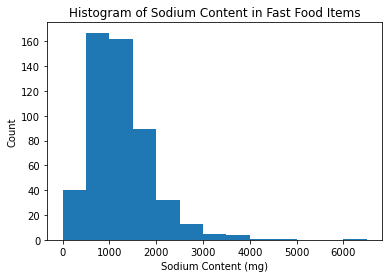

In [2]:
bins = np.arange(0, 7000, 500)
plt.hist(df['sodium'], bins=bins)
plt.ylabel('Count')
plt.xlabel('Sodium Content (mg)')
plt.title('Histogram of Sodium Content in Fast Food Items')
plt.show()

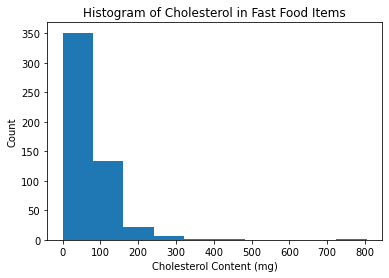

In [3]:
bins = np.arange(0, 900, 100)
plt.hist(df['cholesterol'])
plt.ylabel('Count')
plt.xlabel('Cholesterol Content (mg)')
plt.title('Histogram of Cholesterol in Fast Food Items')
plt.show()